<a href="https://colab.research.google.com/github/letpires/nlp_manchetes_brasileiras/blob/main/topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Como executar este notebook?

Para executar este notebook, é necessário fazer upload do arquivo disponível no mesmo repositório, chamado: 'manchetesBrasildatabase.csv' 

##Conceito

Modelagem de tópicos é uma técnica para extrair os tópicos ocultos de grandes volumes de texto. Latent Dirichlet Allocation (LDA) é um algoritmo popular para modelagem de tópicos com excelentes implementações no pacote Gensim do Python. O desafio, no entanto, é como extrair tópicos de boa qualidade que sejam claros, segregados e significativos . Isso depende muito da qualidade do pré-processamento do texto e da estratégia de encontrar o número ideal de tópicos.

Uma das principais aplicações do processamento de linguagem natural é extrair automaticamente quais tópicos as pessoas estão discutindo de grandes volumes de texto. Alguns exemplos de texto grande podem ser feeds de mídia social, avaliações de clientes de hotéis, filmes, etc., feedbacks de usuários, notícias, e-mails de reclamações de clientes, etc.

Saber o que as pessoas estão falando e compreender seus problemas e opiniões é altamente valioso para empresas, administradores e campanhas políticas. E é realmente difícil ler manualmente em volumes tão grandes e compilar os tópicos.

Portanto, é necessário um algoritmo automatizado que possa ler os documentos de texto e gerar automaticamente os tópicos discutidos.

##Importações 

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import unicodedata

# Importando a library Natural Language Toolkit - NLTK para tratamento de linguagem natural.
import nltk
nltk.download('wordnet')
nltk.download('punkt')

#Importando as stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
language = 'portuguese'

stopwords = stopwords.words(language)
stopwords = list(set(stopwords))

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Plotagem
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Adicionando novas stopwords em português
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append('ja')
stopwords.append('viu')
stopwords.append('vai')
stopwords.append('ne')
stopwords.append('ai')
stopwords.append('ta')
stopwords.append('gente')
stopwords.append('nao')
stopwords.append('aqui')
stopwords.append('tambem')
stopwords.append('vc')
stopwords.append('voce')
stopwords.append('entao')
stopwords.append('ate')
stopwords.append('agora')
stopwords.append('ser')
stopwords.append('sempre')
stopwords.append('ter')
stopwords.append('so')
stopwords.append('porque')
stopwords.append('sobre')
stopwords.append('ainda')
stopwords.append('la')
stopwords.append('tudo')
stopwords.append('ninguem')
stopwords.append('de')

##Coletando os dados 


In [ ]:
caminho = '/content/manchetesBrasildatabase.csv'
dataframe = pd.read_csv(caminho, quotechar="'", header = None, names = ["Day", "Month", "Year", "Company", "Headline"])
dataframe.head()

,Day,Month,Year,Company,Headline
0,1,fevereiro,2017,Valor,BNDES encolhe e volta ao nível de 20 anos atrás
1,1,fevereiro,2017,Valor,BC cria novo instrumento de política monetária.
2,1,fevereiro,2017,Valor,Câmbio gera bate-boca entre UA e UE.
3,1,fevereiro,2017,Valor,Indenização a transmissoras de energia já cheg...
4,1,fevereiro,2017,Valor,"Políticos esperam que relator separe ""joio do ..."


In [ ]:
dataframe_folha = dataframe.loc[dataframe['Company'] == 'Folha']
dataframe_folha

,Day,Month,Year,Company,Headline
14,1,fevereiro,2017,Folha,Crise amplia diferença de salário entre CLT e ...
15,1,fevereiro,2017,Folha,Governo faz cortes após déficit recorde de R$ ...
16,1,fevereiro,2017,Folha,"Vitória é dada como certa no Senado, e PMDB mi..."
17,1,fevereiro,2017,Folha,Operador diz que repatriou propina de Eike a C...
18,1,fevereiro,2017,Folha,Doria quer punir pichadores com multa pesada e...
...,...,...,...,...,...
486,31,dezembro,2016,Folha,"Em um mês, Doria prioriza centro de SP e zelad..."
493,17,julho,2017,Folha,Fernando Haddad: PT e PSDB se mantiveram refén...
494,17,julho,2017,Folha,Plebiscito na Venezuela atrai eleitores contra...
495,17,julho,2017,Folha,Colômbia tenta convencer Cuba a mediar crise n...


In [ ]:
len(dataframe_folha)

127

##Pré-processamento

Nessa fase é onde serão removidos caracteres irrelevantes para a análise, como espaços, \, pontuações, stopwords, letras maiúsculas, caracteres Non ASCII...

In [ ]:
# Convertendo para lista
data = dataframe_folha.Headline.values.tolist()

# Removendo novas linhas
data = [re.sub('\s+', ' ', sent) for sent in data]

# Removendo distrações
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Crise amplia diferença de salário entre CLT e servidor.']


In [ ]:
#Aplicando função para deixar somente letras minúsculas.
def to_lowercase(words):
   
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [ ]:
#Aplicando função para remover os caracteres Non ASCII
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [ ]:
data = to_lowercase(data)

In [ ]:
data = remove_non_ascii(data)
data

['crise amplia diferenca de salario entre clt e servidor.',
 'governo faz cortes apos deficit recorde de r$ 155,7 bilhoes.',
 'vitoria e dada como certa no senado, e pmdb mira comissao.',
 'operador diz que repatriou propina de eike a cabral.',
 'doria quer punir pichadores com multa pesada e trabalho de gari.',
 'pedro parente: brasil nao deveria ter desapreco ao capital estrangeiro.',
 'trump indica juiz conservador para a suprema corte.',
 'obter visto para os eua fica mais dificil para os brasileiros.',
 'comissao rejeita pilares da nova previdencia.',
 'propostas radicais tem chance politica.',
 'elio gaspari: presidente bate recorde em perda de colaboradores.',
 'helio schwartsman: puxadinho vira estrategia para evitar confrontos.',
 'no desempate, tatuape vence pela 1a vez em sp.&nbsp;',
 'trump pode desistir de expulsar ilegais sem crime grave.',
 'maioria da torcida em sp nao sabe nome de jogador.',
 ' bc cita impacto da crise e diz que juro caira menos.',
 'planalto aponta "f

In [ ]:
#Removendo pontuação e fazendo a tokeinização (para conseguir aplicar o modelo LDA)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['crise', 'amplia', 'diferenca', 'de', 'salario', 'entre', 'clt', 'servidor']]


Bigramas são duas palavras que ocorrem frequentemente juntas no documento. Os trigramas são três palavras que ocorrem com freqüência.

In [ ]:
# Construindo os modelos bigrama e trigrama
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # limite superior menos as frases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Maneira mais rápida de obter uma frase batida como um trigrama / bigrama
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['crise', 'amplia', 'diferenca', 'de', 'salario', 'entre', 'clt', 'servidor']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Definindo funções para stopwords, bigrams and trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Removendo Stop Words
data_words_nostops = remove_stopwords(data_words)

# Formando Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

data_words_bigrams

[['crise', 'amplia', 'diferenca', 'salario', 'clt', 'servidor'],
 ['governo', 'faz', 'cortes', 'apos', 'deficit', 'recorde', 'bilhoes'],
 ['vitoria', 'dada', 'certa', 'senado', 'pmdb', 'mira', 'comissao'],
 ['operador', 'diz', 'repatriou', 'propina', 'eike', 'cabral'],
 ['doria',
  'quer',
  'punir',
  'pichadores',
  'multa',
  'pesada',
  'trabalho',
  'gari'],
 ['pedro',
  'parente',
  'brasil',
  'deveria',
  'desapreco',
  'capital',
  'estrangeiro'],
 ['trump', 'indica', 'juiz', 'conservador', 'suprema', 'corte'],
 ['obter', 'visto', 'eua', 'fica', 'dificil', 'brasileiros'],
 ['comissao', 'rejeita', 'pilares', 'nova', 'previdencia'],
 ['propostas', 'radicais', 'chance', 'politica'],
 ['elio',
  'gaspari',
  'presidente',
  'bate',
  'recorde',
  'perda',
  'colaboradores'],
 ['helio',
  'schwartsman',
  'puxadinho',
  'vira',
  'estrategia',
  'evitar',
  'confrontos'],
 ['desempate', 'tatuape', 'vence', 'vez', 'sp', 'nbsp'],
 ['trump', 'pode', 'desistir', 'expulsar', 'ilegais', 

###Criando dicionário e corpus para a modelagem

In [ ]:
# Criando dicionário
id2word = corpora.Dictionary(data_words_bigrams)

# Criando corpus
texts = data_words_bigrams

# Frequencia do documento do termo
corpus = [id2word.doc2bow(text) for text in texts]

# visualizando
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


##Construindo a Modelagem

Temos tudo para treinar o modelo LDA. Além do corpus e do dicionário, você também precisa fornecer o número de tópicos.

Além disso, alphae etasão hiperparâmetros que afetam a dispersão dos tópicos. De acordo com a documentação do Gensim, ambos os padrões são 1.0 / num_topics anterior.

chunksizeé o número de documentos a serem usados ​​em cada bloco de treinamento. update_everydetermina a frequência com que os parâmetros do modelo devem ser atualizados e passesé o número total de passes de treinamento.

In [ ]:
# Construindo LDA Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Imprindo as palavras chaves nos 10 tópicos
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.052*"lava" + 0.052*"jato" + 0.026*"ameaca" + 0.026*"economia" + '
  '0.026*"novo" + 0.026*"pf" + 0.022*"manteve" + 0.022*"repasse" + '
  '0.022*"ilicito" + 0.022*"retomada"'),
 (1,
  '0.042*"lula" + 0.031*"trump" + 0.031*"diz" + 0.028*"menos" + '
  '0.021*"politica" + 0.021*"mesquita" + 0.021*"ministros" + 0.021*"maior" + '
  '0.018*"deflagra" + 0.018*"decreto"'),
 (2,
  '0.042*"pais" + 0.023*"crise" + 0.023*"presidente" + 0.020*"rio" + '
  '0.020*"dias" + 0.020*"afirma" + 0.020*"cada" + 0.017*"colega" + '
  '0.017*"elmar" + 0.017*"nascimento"'),
 (3,
  '0.027*"ataque" + 0.026*"deve" + 0.023*"deixa" + 0.023*"mortos" + '
  '0.023*"helio" + 0.023*"schwartsman" + 0.023*"aposentadoria" + 0.023*"vira" '
  '+ 0.023*"ato" + 0.023*"venezuela"'),
 (4,
  '0.058*"contra" + 0.044*"brasil" + 0.034*"coreia" + 0.034*"cria" + '
  '0.034*"plano" + 0.034*"fuga" + 0.034*"embaixada" + 0.027*"maduro" + '
  '0.024*"reformas" + 0.021*"temer"'),
 (5,
  '0.038*"stf" + 0.025*"oab" + 0.025*"pressiona" 

Como interpretar isso?

O tópico 0 é representado como:'0.009*"doutor" + 0.008*"baba" + 0.008*"andre" + 0.008*"jairinho" + ''0.008*"depoimento" + 0.08*"advogado" + 0.008*"taina" + 0.008*"entrevista" ''+ 0.008*"policia" + 0.08*"equipe"'.

Isso significa que as 10 principais palavras chave que contribuem para este tópico são: doutor, baba, andre, jairinho, depoimento, advogado, taina, entrevista, policia,equipe.

Os pesos de cada uma refletem a importância de uma palavra chave para aquele tópico.

Olhando para essas palavras-chave, você consegue adivinhar qual poderia ser esse tópico? Você pode resumir em 'carros' ou 'automóveis'.

Da mesma forma, você pode examinar as palavras-chave do tópico restantes e julgar qual é o tópico?


EXEMPLO DO TÓPICO 0: podemos entender que as palavras chave do tópico 0 se referem ao caso do Henry. 
Trecho reportagem: "**Polícia** diz que **babá** sabia que Henry havia sido agredido por **Dr.** **Jairinho**"..."O advogado André França Barreto afirmou que o casal, preso na semana".

Exemplo de como podemos representar graficamente:

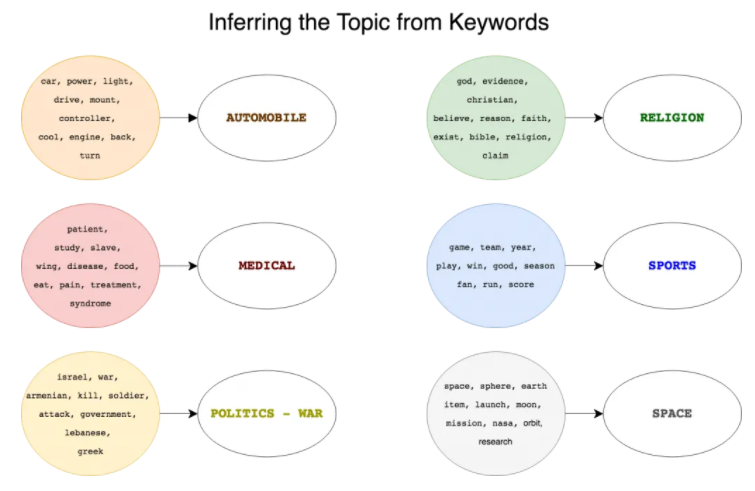

##Calculando a pontuação de perplexidade e coerência do modelo

A perplexidade do modelo e a coerência do tópico fornecem uma medida conveniente para julgar o quão bom é um determinado modelo de tópico

In [ ]:
# Calculando a perplexidade
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Calculando o score de coerência
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.159332843501972

Coherence Score:  0.6201033937253544


##Número ideal de tópicos?

A abordagem se baseia em encontrar o número ideal de tópicos é construir muitos modelos de LDA com diferentes valores de número de tópicos (k) e escolher aquele que fornece o maior valor de coerência.

In [ ]:
# Função para determinar a melhor quantidade de tópicos para a modelagem
def compute_coherence_values(dictionary, corpus, texts, limit, start=3, step=3):
    """
    Compute c_v coherence para vários números de tópicos

    Parâmetros passados:
    ----------
    dicionário : Gensim dicionário
    corpus : Gensim corpus
    texto : Lista com os textos de entrada
    limite : número máximo de tópicos

    Retorno:
    -------
    model_list : Lista de modelos de tópicos de LDA
    coherence_values : Valor de coerência correspondente ao modelo LDA com o respectivo número de tópicos.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=3, limit=40, step=6)

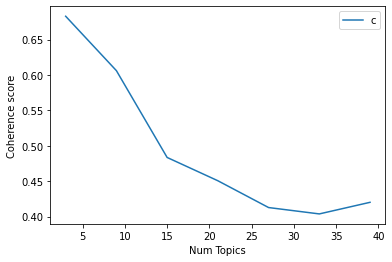

In [ ]:
# Show graph
limit=40; start=3; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 3  tem um valor de coerência de  0.683
A quantidade de tópicos = 9  tem um valor de coerência de  0.6061
A quantidade de tópicos = 15  tem um valor de coerência de  0.4835
A quantidade de tópicos = 21  tem um valor de coerência de  0.4506
A quantidade de tópicos = 27  tem um valor de coerência de  0.4127
A quantidade de tópicos = 33  tem um valor de coerência de  0.4037
A quantidade de tópicos = 39  tem um valor de coerência de  0.4201


Se a pontuação de coerência parece continuar aumentando, pode fazer mais sentido escolher o modelo que forneceu o CV mais alto antes de nivelar. 

Portanto, para as próximas etapas, irei escolher o modelo com 32
tópicos próprios.

In [ ]:
# Selecionando o modelo  e imprimindo os tópicos.
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.011*"presidente" + 0.007*"ataque" + 0.007*"deixa" + 0.007*"temer" + '
  '0.007*"diz" + 0.006*"pais" + 0.005*"ano" + 0.005*"reformas" + 0.005*"apoio" '
  '+ 0.005*"esquerda"'),
 (1,
  '0.010*"deve" + 0.010*"governo" + 0.008*"trump" + 0.007*"apos" + '
  '0.006*"maduro" + 0.006*"pais" + 0.006*"contra" + 0.006*"camara" + '
  '0.005*"stf" + 0.005*"brasil"'),
 (2,
  '0.013*"diz" + 0.011*"temer" + 0.009*"crise" + 0.009*"menos" + 0.008*"doria" '
  '+ 0.006*"preciso" + 0.005*"odebrecht" + 0.005*"lula" + 0.005*"sociedade" + '
  '0.005*"poder"')]


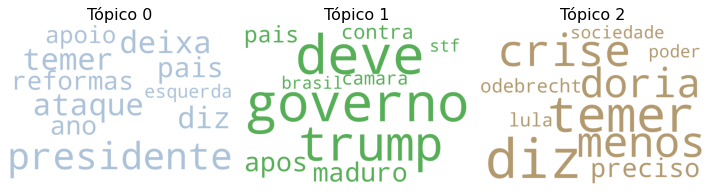

In [ ]:
# Criando wordclouds
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = optimal_model.show_topics(formatted=False)
fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Tópico ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##Encontrando o tópico dominante em cada frase

Uma das aplicações práticas da modelagem de tópicos é determinar de que tópico um determinado documento trata.

Para descobrir isso, encontramos o número do tópico que tem a maior contribuição percentual naquele documento.

A função abaixo agrega agradavelmente essas informações em uma tabela apresentável.format_topics_sentences()

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Saída inicial
    sent_topics_df = pd.DataFrame()

    # Obtém o tópico principal em cada documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Obtém o tópico dominante, contribuição em percentual e palavras-chave para cada documento
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => tópico dominante
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Tópico dominante', 'Percentual de Contribuição', 'Palavras Chave']

    # Adiciona o texto original no final da saída
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Formatando
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Número do documento', 'Tópico dominante', 'Perc. de Contribuição do Tópico', 'Palavras Chave', 'Transcription']

# Mostre
df_dominant_topic.head(10)

,Número do documento,Tópico dominante,Perc. de Contribuição do Tópico,Palavras Chave,Transcription
0,0,12.0,0.8643,"temer, pressionam, diferenca, forca, prisao, d...",crise amplia diferenca de salario entre clt e ...
1,1,4.0,0.8812,"temer, diz, rio, crise, presidente, recorde, b...",governo faz cortes apos deficit recorde de r$ ...
2,2,0.0,0.8812,"pessimismo, ato, bolsonaro, franco, jato, stf,...","vitoria e dada como certa no senado, e pmdb mi..."
3,3,15.0,0.8643,"doria, nova, conta, fila, lei, gorjetas, garco...",operador diz que repatriou propina de eike a c...
4,4,9.0,0.8944,"brasil, ofensiva, dez, seis, pedido, cria, mes...",doria quer punir pichadores com multa pesada e...
5,5,9.0,0.8812,"brasil, ofensiva, dez, seis, pedido, cria, mes...",pedro parente: brasil nao deveria ter desaprec...
6,6,15.0,0.8643,"doria, nova, conta, fila, lei, gorjetas, garco...",trump indica juiz conservador para a suprema c...
7,7,3.0,0.8643,"admite, dificil, brasileiros, mi, rolls, royce...",obter visto para os eua fica mais dificil para...
8,8,10.0,0.8417,"nova, menos, adiar, carceragem, pf, rejeita, p...",comissao rejeita pilares da nova previdencia.
9,9,5.0,0.8100,"politica, maioria, carencia, ansiedade, preve,...",propostas radicais tem chance politica.


##Referências




[Gensim Topic Modelling](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=%2C%20per_word_topics%3DTrue-,13.,certain%20weightage%20to%20the%20topic.)

[Como modelar tópicos através de Latent Dirichlet Allocation (LDA) através da biblioteca Gensim](https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b)

[Topic Modeling and Latent Dirichlet Allocation (LDA) in Python](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

[Avaliar Modelos de Tópico: Alocação Latente de Dirichlet (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

